# Atividade Prática 3

Nesta atividade, o algoritmo de evolução diferencial será implementado e utilizado na minimização da função _Peaks_, comumente utilizada para testar o desempenho de métodos de otimização por ser não-linear, não-convexa e multimodal.

O presente estudo se divide em três seções: <a href="#implement">implementação</a> do DE, <a href="#teste">teste</a> do DE com a função _Peaks_ e a <a href="#discuss">discussão</a> dos resultados obtidos.

---

<h2 id="implement">Implementação</h2>

#### Bibliotecas necessárias

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### Funções e targets para teste do algoritmo

In [2]:
# Função Peaks
def peaks(x):
    x = x.T
    F = 3*(1-x[0])**2 * np.exp(-(x[0]**2) - (x[1]+1)**2) - 10*(x[0]/5 - x[0]**3 - x[1]**5) * np.exp(-x[0]**2-x[1]**2) - 1/3*np.exp(-(x[0]+1)**2 - x[1]**2)
    return F
#
# Target da função Peaks
peaksTarget = -6.5511

#### Implementação

In [3]:
# Funções auxiliares

def peaksFitness(indiv):
    '''Retorna erro absoluto entre a avaliação do indivíduo na função alvo (peaks)
        e o target da função'''
    global peaksTarget
    return(np.abs(peaksTarget - peaks(indiv)))

def bestIndividual(pop, fitFunction):
    '''Retorna o melhor indivíduo da população, baseado na função de fitness'''
    indexedFitness = np.zeros([pop.shape[1], 2])
    for j in range(pop.shape[1]):
        indexedFitness[j,:] = [j, fitFunction(pop[:,j])]
    return(pop[:,indexedFitness[:,1].argsort()[0]])

In [4]:
# Loop para evolução da população
def diffEvolution(pop, fitFunction, recombRate, scaleFactor, meanError=1, minimize=1, tol=0.05, maxiter=2000):
    pop = pop.copy()
    newPop = pop.copy()
    
    # n = número de genes; N = tamanho da população
    n, N = pop.shape
    
    # O parâmetro meanError determina se o algoritmo vai se basear no fitness médio da população ou no do 
    # melhor indivíduo. Por padrão, ele se baseia no erro médio.
    if not(meanError):
        error = fitFunction(bestIndividual(pop, fitFunction))
    else:
        error = np.mean([fitFunction(pop[:,i]) for i in range(pop.shape[1])])
    
    niter = 0
    while error > tol and niter < maxiter:
        for i in range(N):
            # Seleciona valores uniformemente em [0, N-1]
            r1, r2, r3, deltai = [int(i) for i in np.random.uniform(0, N-1, 4)]
            for j in range(n):
                # Com probabilidade recombRate, aplica-se mutação a um indivíduo
                if recombRate >= np.random.uniform(0, 1, 1) or j==deltai:
                    newPop[j,i] = pop[j,r1] + scaleFactor*(pop[j,r2] - pop[j,r3])
            if (minimize and (fitFunction(newPop[:,i])<=fitFunction(pop[:,i])) or
                not(minimize) and (fitFunction(newPop[:,i])>=fitFunction(pop[:,i]))):
                # Se o indivíduo mutante é melhor que algum original, o último é substituído
                # pelo primeiro
                pop[:,i] = newPop[:,i]
        
        # Avalia população
        if not(meanError):
            error = fitFunction(bestIndividual(pop, fitFunction))
        else:
            error = np.mean([fitFunction(pop[:,i]) for i in range(pop.shape[1])])
        
        niter += 1
    return(pop, niter)

In [5]:
# Inicialização da população
def initPopulation(n, N, axLimits=[-3,3]):
    pop = np.zeros([n,N])
    for i in range(n):
        for j in range(N):
            pop[i,j] = np.random.uniform(axLimits[0], axLimits[1], 1)
    return(pop)

---

<h2 id="teste">Testes</h2>

### 1. Testes iniciais: apenas uma iteração

#### 1.1. Função Peaks

Número de iterações: 25


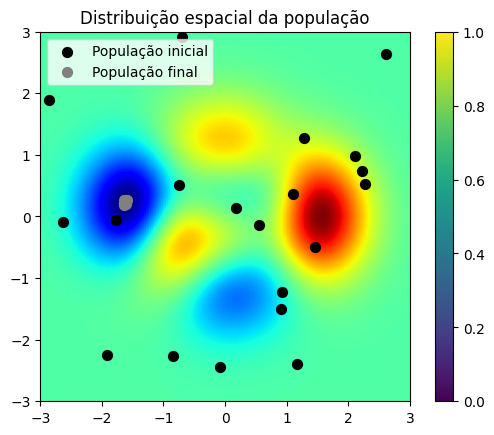

In [6]:
initPopPeaks = initPopulation(2,20)
finalPopPeaks, niterPeaks = diffEvolution(initPopPeaks, peaksFitness, recombRate=0.8, scaleFactor=0.8, meanError=1, tol=0.01)
print(f'Número de iterações: {niterPeaks}')

from itertools import product

x1 = x2 = np.linspace(-3, 3, 150)
x_p = np.array(list(product(x1,x2)))

# Peaks
zPeaks = np.apply_along_axis(peaks, 1, x_p)
z = zPeaks.reshape((len(x1), len(x2)))
initPop = initPopPeaks
finalPop = finalPopPeaks

plt.xlim(-3,3)
plt.ylim(-3,3)
plt.imshow(z, extent=(-3,3,-3,3), origin='lower', cmap='jet')
plt.scatter(initPop[1, :], initPop[0, :], color='black', s=50, marker='o', label='População inicial')
plt.scatter(finalPop[1, :], finalPop[0, :], color='grey', s=50, marker='o', label='População final')
plt.colorbar()
plt.legend()
plt.title('Distribuição espacial da população')
plt.show()

### 2. Testes estatísticos

#### 2.1) Número médio de iterações para hiperparâmetros arbitrários

In [7]:
totalItersPeaks = np.array([])
for i in range(100):
    initPopPeaks = initPopulation(2,20)
    finalPopPeaks, niterPeaks = diffEvolution(initPopPeaks, peaksFitness, recombRate=0.8, scaleFactor=0.8, meanError=1, tol=0.01, maxiter=5000)
    totalItersPeaks = np.append(totalItersPeaks, niterPeaks)
    
meanIterPeaks = round(np.mean(totalItersPeaks),3)
stdIterPeaks = round(np.std(totalItersPeaks),3)
print(f'''Número médio de iterações para convergência (Peaks): {meanIterPeaks}
Desvio-padrão do número de iterações para convergência (Peaks): {stdIterPeaks}''')

Número médio de iterações para convergência (Peaks): 29.31
Desvio-padrão do número de iterações para convergência (Peaks): 4.791


In [8]:
from tqdm import tqdm
from IPython.display import clear_output

# Grid search para seleção de hiperparâmetros na min. da função Peaks
itersPeaksVariableCAndF = np.zeros((25,3))
iter = 0
for recombRate in tqdm(np.linspace(0.6, 0.9, 5)):
    for scaleFactor in np.linspace(0.7, 0.9, 5):
            totalItersPeaks = np.array([])
            for i in range(10):
                initPopPeaks = initPopulation(2,20)
                finalPopPeaks, niterPeaks = diffEvolution(initPopPeaks, peaksFitness, recombRate=recombRate, scaleFactor=scaleFactor, meanError=1, tol=0.01, maxiter=5000)
                totalItersPeaks = np.append(totalItersPeaks, niterPeaks)
            itersPeaksVariableCAndF[iter] = [recombRate, scaleFactor, np.mean(totalItersPeaks)]
            iter+=1
CstarPeaks, FstarPeaks, niterHPOpeaks = itersPeaksVariableCAndF[itersPeaksVariableCAndF[:,2].argmin(), :]
clear_output(wait=1)

print(f'''\nOs melhores valores obtidos para a probabilidade de recombinação e para o fator de escala são,
respectivamente, {CstarPeaks} e {FstarPeaks} na minimização da função Peaks. Número médio de iterações
com esses hiperparâmetros: {niterHPOpeaks}''')


Os melhores valores obtidos para a probabilidade de recombinação e para o fator de escala são,
respectivamente, 0.9 e 0.75 na minimização da função Peaks. Número médio de iterações
com esses hiperparâmetros: 23.8


---

<h2 id="discuss">Discussão</h2>

Os experimentos realizados demonstraram a enorme eficácia do algoritmo de evolução diferencial em problemas de otimização. Mesmo para uma função multimodal, não-linear e não-convexa, o algoritmo convergiu para o mínimo global em pouquíssimas iterações e com um custo computacional muito baixo.

O algoritmo ainda se mostrou pouco sensível à tunagem de hiperparâmetros, obtendo bons resultados para todas as combinações de parâmetros testadas. O número médio de iterações até a convergência foi, em geral, menor que o observado para a função de Rastrigin. 

Por fim, o algoritmo ainda apresentou baixa variância, se mostrando robusto, apesar de estocástico.

---